In [17]:
# Cell 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image


In [18]:
# Cell 2: Dataset Class
class PlantDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = f"{self.root_dir}/{self.data.iloc[idx, 0]}"
        label = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [19]:
# Cell 3: Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(224, padding=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [20]:
# Cell 4: Load Data
train_df = pd.read_csv("dataset/train.csv")
val_df = pd.read_csv("dataset/val.csv")
test_df = pd.read_csv("dataset/test.csv")

train_dataset = PlantDataset(dataframe=train_df, root_dir="dataset/", transform=transform)
val_dataset = PlantDataset(dataframe=val_df, root_dir="dataset/", transform=transform)
test_dataset = PlantDataset(dataframe=test_df, root_dir="dataset/", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:

class ImprovedPlantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedPlantClassifier, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # Adaptive Pooling and Fully Connected Layers
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Pooling and Fully Connected Layers
        x = self.pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [22]:
# Cell 6: Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedPlantClassifier(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


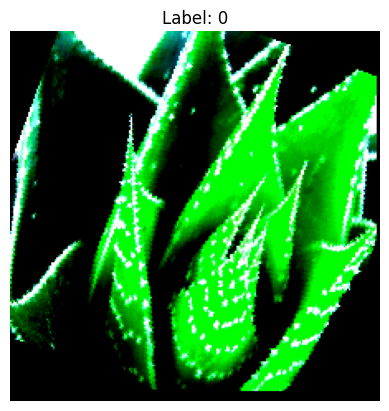

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2042704].


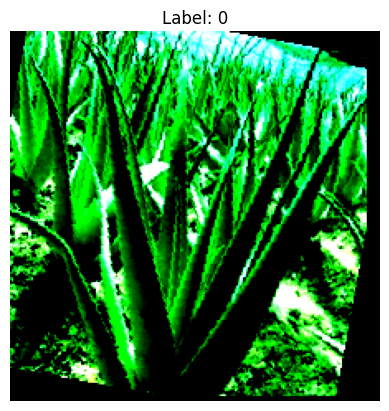

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


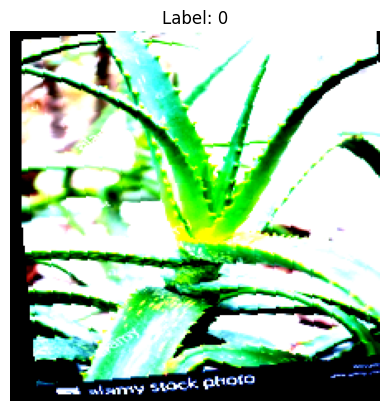

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


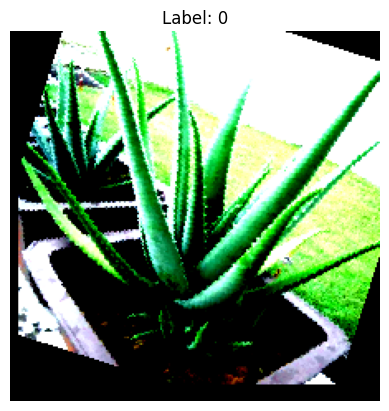

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].


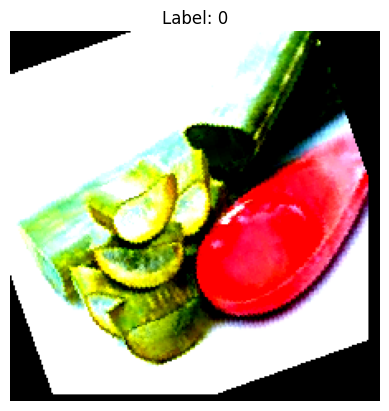

In [23]:
import matplotlib.pyplot as plt

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image.permute(1, 2, 0).numpy())  # Convert from CxHxW to HxWxC for display
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


In [24]:
# Cell 7: Training Loop
num_epochs = 15
train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total * 100
    val_accuracies.append(val_accuracy)

    scheduler.step()  # Adjust learning rate

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


KeyboardInterrupt: 

In [ ]:
# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 8: Evaluate Model
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(30)]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(30)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

# Initialize true and predicted labels
y_true, y_pred = [], []

# Evaluate the model on the test dataset
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate the F1 score (macro, micro, weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(30)]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(30)])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Cell 9: Save Model
torch.save(model.state_dict(), "pc3.pth")
print("Model saved as 'pc3.pth'")


In [3]:
import torch
torch.cuda.empty_cache()
